In [1]:
# Untuk mengupload dari drive lokal 
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install -q keras

In [3]:
# Impor library yang di perlukan
import keras
import numpy as np
import pandas as pd
from keras.layers import Bidirectional
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# Ubah dataset menjadi dataframe dengan fungsi read_csv(). 
# Tampilkan 5 data teratas pada dataframe menggunakan fungsi head().
data_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Electricity Consumption/train.csv')
data_train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [5]:
# Untuk menampilkan jumlah colomns dan data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


In [6]:
# Mengecek apakah ada nilai yang hilang dari dataset menggunakan fungsi isnull().
data_train.isnull().sum()

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

In [7]:
date = data_train['datetime']
temp = data_train['temperature']
print(temp.shape)
print(temp)

(26496,)
0       -11.4
1       -12.1
2       -12.9
3       -11.4
4       -11.4
         ... 
26491    -0.7
26492    -2.9
26493    -1.4
26494    -2.9
26495    -2.1
Name: temperature, Length: 26496, dtype: float64


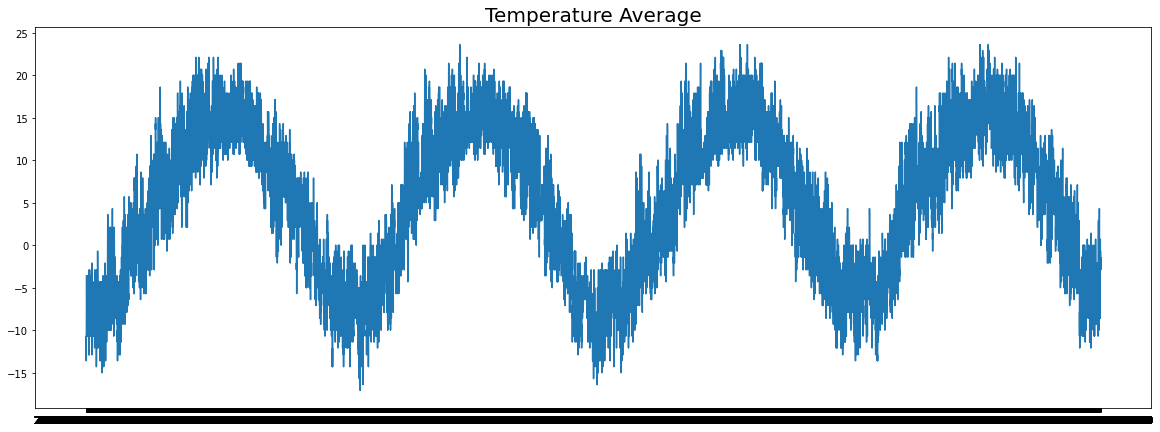

In [8]:
# Untuk membuat plot dari data kita dapat menggunakan fungsi plot dari library matplotlib.
# Output cell yang kita jalankan menunjukkan bahwa data kita merupakan time series yang bersifat penggunaan.
date = data_train['datetime'].values
temp = data_train['temperature'].values

plt.figure(figsize=(20,7))
plt.plot(date, temp)
plt.title('Temperature Average',
          fontsize=20);

In [9]:
# Split jadi train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(date, temp, test_size=0.2)

In [10]:
# Konversi teks ke tfidf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
# Fit hanya berdasarkan data train
tokenizer.fit_on_texts(X_train)
# Konversi train
seq_x_train = tokenizer.texts_to_sequences(X_train)
X_enc_train = tokenizer.sequences_to_matrix(seq_x_train,mode="tfidf")
# Konversi test
seq_x_test  = tokenizer.texts_to_sequences(X_test)
X_enc_test  = tokenizer.sequences_to_matrix(seq_x_test,mode="tfidf")
 
print(X_enc_train.shape)
print(X_enc_test.shape)
print(X_enc_train)

(21196, 30)
(5300, 30)
[[0.         1.17356026 0.         ... 0.         0.         2.5798855 ]
 [0.         1.17356026 0.         ... 0.         0.         0.        ]
 [0.         1.17356026 0.         ... 0.         0.         0.        ]
 ...
 [0.         1.17356026 0.         ... 0.         0.         0.        ]
 [0.         1.17356026 0.         ... 0.         0.         0.        ]
 [0.         1.17356026 0.         ... 0.         0.         0.        ]]


In [11]:
# Untuk merubah data kita menjadi format yang dapat diterima oleh model. 
# Fungsi di bawah menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, 
# Kemudian mengembalikan label dan atribut dari dataset dalam bentuk batch.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
# Untuk arsitektur model gunakan 2 buah layer LSTM.
# Ketika menggunakan 2 buah layer LSTM, perhatikan bahwa layer pertama harus memiliki parameter return_sequences yang bernilai True.
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
# Pada optimizer, kita akan menggunakan parameter learning rate dan momentum
# Loss function yang dapat dicoba untuk ini adalah Huber yang merupakan salah satu loss function yang umum digunakan pada kasus time series.
# Serta metrik yang digunakan untuk mengevaluasi model adalah MAE.
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Untuk mengetahui nilai data rata-rata, terkecil, dan terbesar pada colom AEP_MW
temp = np.array(data_train['temperature'])
print(temp)
print("temperature terkecil:    ", temp.min())
print("temperature terbesar:    ", temp.max())
print("temperature rata-rata:   ", temp.mean())

[-11.4 -12.1 -12.9 ...  -1.4  -2.9  -2.1]
temperature terkecil:     -17.1
temperature terbesar:     23.6
temperature rata-rata:    5.098988526570049


In [15]:
# Mengimplementasikan callback
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') is not None and logs.get('mae') <= 4.07):  
      # Do something else
      self.model.stop_training = True

custom_callback = stopTraining()

In [16]:
# Menggunakan 30 epoch. atau bebas bereksperimen dengan nilai yang lain
# Mulai melatih model kita dengan memanggil fungsi fit()
num_epochs = 30
history = model.fit(train_set, epochs=num_epochs, batch_size=2, steps_per_epoch=30, 
                    validation_data=test_set, callbacks=[custom_callback])

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 27s 888ms/step - loss: 7.4903 - mae: 7.9775 - val_loss: 7.8847 - val_mae: 8.3747
Epoch 2/30
30/30 [==============================] - 29s 953ms/step - loss: 8.3055 - mae: 8.7973 - val_loss: 6.4094 - val_mae: 6.8985
Epoch 3/30
30/30 [==============================] - 25s 829ms/step - loss: 4.5664 - mae: 5.0503 - val_loss: 3.7954 - val_mae: 4.2742
Epoch 4/30
30/30 [==============================] - 25s 845ms/step - loss: 3.3020 - mae: 3.7764 - val_loss: 3

In [17]:
# Menguji akurasi prediksi model pada data uji val_loss & val_mae
results = model.evaluate(test_set,)
print("Hasil  [val_loss,val_mae] untuk data test:")
print(results)

265/265 [==============================] - 20s 75ms/step - loss: 3.8776 - mae: 4.3576
Hasil  [val_loss,val_mae] untuk data test:
[3.877629280090332, 4.3575615882873535]


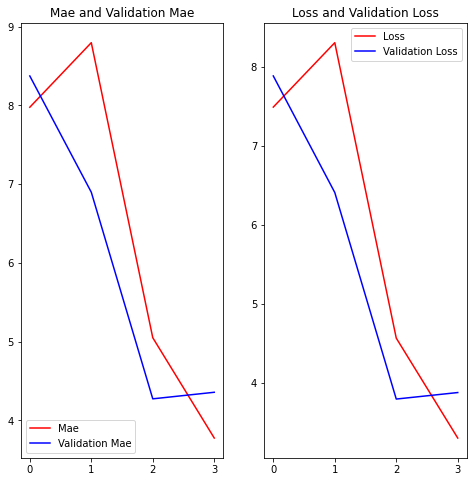

In [18]:
# Membuat plot mae atau loss dari model. Kode di bawah menunjukkan bagaimana kita bisa membuat plot loss dan mae dari model
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, 'r', label='Mae')
plt.plot(epochs_range, val_mae, 'b', label='Validation Mae')
plt.legend(loc='lower left')
plt.title('Mae and Validation Mae')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'r', label='Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss and Validation Loss')
plt.show()